In [1]:
from olfactory_import import *
from olfactory_util import *
from olfactory_model import *

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
odor_te = [0] # which odor is used for test
model_flag = 1 # 1-8, correspond to different noise structures
kernel_flag = 'mixture' # linear,rbf,mixture to formulate latent kernel
trial_flag = 0 # 0: trial-average, 1: multi-trial
R = 2 # rank of the noise matrix
dname = 'syn_2d.mat'

K = 2 # latent dimensionality
n_flag = 4 # 1-4, initialization for noise 
n_iter = 2000
n_print = 500
n_iter_test = 1000
n_print_test = 500
n_samples = 1

In [3]:
# load data
syn_data = scipy.io.loadmat(dname)
x_true0 = syn_data['x_true0'] # mean firing rate
x_true = syn_data['x_true'] # observed firing rate
xgrid = syn_data['xgrid']
z_true = syn_data['z_true']
zgrid = syn_data['zgrid']
tgrid = syn_data['tgrid']
Kz_true = syn_data['Kz']
Sigma_odor = syn_data['Sigma_odor']
Sigma_neuron = syn_data['Sigma_neuron']
so0 = syn_data['so'].flatten()
sn0 = syn_data['sn'].flatten()
T = syn_data['T'][0][0]
N = syn_data['N'][0][0]
D = syn_data['D'][0][0]

# re-arrange data into the needed formats 
x_true = x_true.reshape(T,N,D)
print(x_true.shape)

odor_num = np.arange(x_true.shape[1])
odor_tr = np.delete(odor_num, odor_te)

# split training and test sets along odor dimension
x_true_train, x_true_test = \
x_true[:,odor_tr,:],x_true[:,odor_te,:]

T = x_true_train.shape[0]
N_tr = x_true_train.shape[1]
N_te = x_true_test.shape[1]
D = x_true_train.shape[2]
print('trials:', T, '  neurons:', D, '  training odors:', N_tr, '  test odors:', N_te)

x_true_avg_train = np.mean(x_true_train,0).reshape(N_tr,D) # trial-average
x_true_avg_test = np.mean(x_true_test,0).reshape(N_te,D) # trial-average
x_true_trial_train = np.reshape(x_true_train,(T,-1)) 
x_true_trial_test = np.reshape(x_true_test,(T,-1)) 

(10, 20, 50)
trials: 10   neurons: 50   training odors: 19   test odors: 1


In [4]:
# split test set into test_val and test_test along neuron dimension for co-smoothing
neuron_va = list(range(0,45))
neuron_te = list(range(45,D))

x_true_avg_test_va = x_true_avg_test[:,neuron_va]
x_true_avg_test_te = x_true_avg_test[:,neuron_te]
D_va = x_true_avg_test_va.shape[1]
D_te = x_true_avg_test_te.shape[1]
print('D_va:', D_va, '  D_te:', D_te)

x_true_avg_va = np.vstack((x_true_avg_train[:,neuron_va],x_true_avg_test_va))

x_true_trial_test_va = x_true_trial_test.reshape(T,N_te,D)[:,:,neuron_va].swapaxes(1,2)
x_true_trial_test_te = x_true_trial_test.reshape(T,N_te,D)[:,:,neuron_te].swapaxes(1,2)
x_true_trial_train_va = x_true_trial_train.reshape(T,N_tr,D)[:,:,neuron_va].swapaxes(1,2)
x_true_trial_train_te = x_true_trial_train.reshape(T,N_tr,D)[:,:,neuron_te].swapaxes(1,2)
x_true_trial_va = np.dstack((x_true_trial_train_va,x_true_trial_test_va)).swapaxes(1,2).reshape(T,-1)

print(x_true_avg_va.shape)
print(x_true_trial_test_va.shape)
print(x_true_trial_test_te.shape)
print(x_true_trial_train_va.shape)
print(x_true_trial_train_te.shape)
print(x_true_trial_va.shape)

print("Number of training points N_tr={}".format(N_tr))
print("Number of test points N_te={}".format(N_te))
print("Number of features D={}".format(D))
print("Number of latent dimensions K={}".format(K))
print("Number of trials T={}".format(T))

D_va: 45   D_te: 5
(20, 45)
(10, 45, 1)
(10, 5, 1)
(10, 45, 19)
(10, 5, 19)
(10, 900)
Number of training points N_tr=19
Number of test points N_te=1
Number of features D=50
Number of latent dimensions K=2
Number of trials T=10


In [5]:
# initialization for z
z_init_tr = x_true_avg_train[:,:K]
z_init_va = np.ones((N_te,K))
print('z_init_tr ',z_init_tr.shape)
print('z_init_va ',z_init_va.shape)
z_init = np.vstack((z_init_tr,z_init_va))
print('z_init ',z_init.shape)

z_init_tr  (19, 2)
z_init_va  (1, 2)
z_init  (20, 2)


In [6]:
# hyperparameter initialization for prior kernel for latent z
sig_f_w = tf.nn.softplus(var(softplus_inv(1)*1))
F = 1 # dimensionality of the lengthscale for the prior kernel, 1 or N_tr
l_w = tf.nn.softplus(var(softplus_inv(np.ones(F)*10)))
sig_n_w = tf.nn.softplus(var(softplus_inv(np.ones(N_tr)*1)))
K_w = tf.diag(sig_n_w)
print(K_w.shape)

# hyperparameter initialization for latent kernel for mean firing rate
coeff_linear = tf.nn.softplus(var(softplus_inv(1)))
coeff_rbf = tf.nn.softplus(var(softplus_inv(1)))
sig_f_z = tf.nn.softplus(var(softplus_inv(1)*1))
l_z = tf.nn.softplus(var(softplus_inv(np.ones(K)*1)))
l_z1 = tf.nn.softplus(var(softplus_inv(np.ones(1)*10)))


(19, 19)


In [7]:
# initialize noise across neurons and odors for observed firing rates
# four possible initializations
if n_flag==1: 
    # sig_n_z and sig_o_z are initialized randomly, 
    # B_n and B_o are initialized from data variance using pca
    sn = np.random.randn(D)
    so = np.random.randn(N_tr)
    sig_n_z = tf.nn.softplus(var(softplus_inv(np.abs(sn*1e-2))))
    sig_o_z = tf.nn.softplus(var(softplus_inv(np.abs(so*1e-2))))
    var_n = np.var(x_true_trial_train,axis=0).reshape(N_tr,D)
    pca = PCA(n_components=R)
    Bn = var(pca.fit_transform(var_n.T))
    Bo = var(pca.fit_transform(var_n))
    l_B_n = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_n = tf.matmul(Bn,tf.matmul(tf.diag(l_B_n),tf.transpose(Bn)))+tf.diag(sig_n_z)
    l_B_o = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_o = tf.matmul(Bo,tf.matmul(tf.diag(l_B_o),tf.transpose(Bo)))+tf.diag(sig_o_z)
elif n_flag==2: 
    # sig_n_z and sig_o_z are initialized from data variance, 
    # B_n and B_o are initialized from data variance using pca
    vv = np.var(x_true_trial_train,axis=0)
    u,s,vh = np.linalg.svd(vv.reshape(N_tr,D))
    so = u[:,0]*np.sqrt(s[0])
    sn = vh[0,:]*np.sqrt(s[0])
    sig_n_z = tf.nn.softplus(var(softplus_inv(np.abs(sn*1e-2))))
    sig_o_z = tf.nn.softplus(var(softplus_inv(np.abs(so*1e-2))))
    var_n = np.var(x_true_trial_train,axis=0).reshape(N_tr,D)
    pca = PCA(n_components=R)
    Bn = var(pca.fit_transform(var_n.T))
    Bo = var(pca.fit_transform(var_n))
    l_B_n = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_n = tf.matmul(Bn,tf.matmul(tf.diag(l_B_n),tf.transpose(Bn)))+tf.diag(sig_n_z)
    l_B_o = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_o = tf.matmul(Bo,tf.matmul(tf.diag(l_B_o),tf.transpose(Bo)))+tf.diag(sig_o_z)
elif n_flag==3:
    # sig_n_z and sig_o_z are initialized randomly, 
    # B_n and B_o are initialized from data variance by calculating empirical cov
    sn = np.random.randn(D)
    so = np.random.randn(N_tr)
    sig_n_z = tf.nn.softplus(var(softplus_inv(np.abs(sn*1e-2))))
    sig_o_z = tf.nn.softplus(var(softplus_inv(np.abs(so*1e-2))))
    mm = np.mean(x_true_trial_train.T,1)
    xx1 = (x_true_trial_train-mm).T
    pp = np.zeros((D,D))
    qq = np.zeros((N_tr,N_tr))
    for ii in range(N_tr):
        for jj in range(N_tr):
            cci = np.dot(xx1[ii*D:(ii+1)*D,:], xx1[jj*D:(jj+1)*D,:].T)/(T-1)
            pp = pp+cci/N_tr/N_tr
            qq[ii,jj] = np.mean(cci)*D
    u,s,v = np.linalg.svd(pp)
    ppL = np.dot(u[:,:R], np.diag(np.sqrt(s[:R])))
    u,s,v = np.linalg.svd(qq)
    qqL = np.dot(u[:,:R], np.diag(np.sqrt(s[:R])))
    Bn = var(ppL)
    Bo = var(qqL)
    l_B_n = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_n = tf.matmul(Bn,tf.matmul(tf.diag(l_B_n),tf.transpose(Bn)))+tf.diag(sig_n_z)
    l_B_o = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_o = tf.matmul(Bo,tf.matmul(tf.diag(l_B_o),tf.transpose(Bo)))+tf.diag(sig_o_z)
elif n_flag==4:
    # sig_n_z and sig_o_z are initialized from data variance, 
    # B_n and B_o are initialized from data variance by calculating empirical cov
    vv = np.var(x_true_trial_train,axis=0)
    u,s,vh = np.linalg.svd(vv.reshape(N_tr,D))
    so = u[:,0]*np.sqrt(s[0])
    sn = vh[0,:]*np.sqrt(s[0])
    sig_n_z = tf.nn.softplus(var(softplus_inv(np.abs(sn*1e-2))))
    sig_o_z = tf.nn.softplus(var(softplus_inv(np.abs(so*1e-2))))
    mm = np.mean(x_true_trial_train.T,1)
    xx1 = (x_true_trial_train-mm).T
    pp = np.zeros((D,D))
    qq = np.zeros((N_tr,N_tr))
    for ii in range(N_tr):
        for jj in range(N_tr):
            cci = np.dot(xx1[ii*D:(ii+1)*D,:], xx1[jj*D:(jj+1)*D,:].T)/(T-1)
            pp = pp+cci/N_tr/N_tr
            qq[ii,jj] = np.mean(cci)*D
    u,s,v = np.linalg.svd(pp)
    ppL = np.dot(u[:,:R], np.diag(np.sqrt(s[:R])))
    u,s,v = np.linalg.svd(qq)
    qqL = np.dot(u[:,:R], np.diag(np.sqrt(s[:R])))
    Bn = var(ppL)
    Bo = var(qqL)
    l_B_n = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_n = tf.matmul(Bn,tf.matmul(tf.diag(l_B_n),tf.transpose(Bn)))+tf.diag(sig_n_z)
    l_B_o = tf.nn.softplus(var(softplus_inv(np.ones(R)*1e-2)))
    B_o = tf.matmul(Bo,tf.matmul(tf.diag(l_B_o),tf.transpose(Bo)))+tf.diag(sig_o_z)

print('sn:', sn.shape, '  so:', so.shape, '  B_n:', B_n.shape, '  B_o:', B_o.shape)

sn: (50,)   so: (19,)   B_n: (50, 50)   B_o: (19, 19)


Next we overwrite initialization and structure for sig_n_z, sig_o_z, B_n, and B_o given different model assumptions. The model index 1-8 correspond to the following structures.
<img src="noise_structure.png" width="400" height="200">

In [8]:
# overwrite initialization and structure for sig_n_z, sig_o_z, B_n, and B_o given different model assumptions
if model_flag==1:
    sig_n_z = tf.ones(D)
    B_n = tf.diag(sig_n_z)
    B_o = tf.diag(sig_o_z)
if model_flag==2:
    sig_o_z = tf.ones(N_tr)
    B_n = tf.diag(sig_n_z)
    B_o = tf.diag(sig_o_z)
if model_flag==3:
    B_n = tf.diag(sig_n_z)
    B_o = tf.diag(sig_o_z)
if model_flag==4:
    B_o = tf.diag(sig_o_z)
if model_flag==5:
    B_n = tf.diag(sig_n_z)
if model_flag==7: 
    sig_n_z = tf.ones(D)
    B_n = tf.diag(sig_n_z)
if model_flag==8: 
    sig_o_z = tf.ones(N_tr)
    B_o = tf.diag(sig_o_z)

In [9]:
# distribution for latent
z = MultivariateNormalTriL(loc=tf.zeros((K,N_tr)), scale_tril=tf.cholesky(K_w))
z1 = tf.matmul(tf.transpose(z),tf.diag(tf.sqrt(l_z)))
qz = Normal(loc=var(z_init_tr.T), scale=tf.nn.softplus(var(softplus_inv(np.ones((K,N_tr))*1e-2))))
if kernel_flag == "rbf":
    K_z1 = rbf(z1,lengthscale=l_z1,variance=sig_f_z)
elif kernel_flag == "linear":    
    K_z1 = tf.matmul(z1,tf.transpose(z1))
elif kernel_flag == "mixture":
    K_z1 = rbf(z1,lengthscale=l_z1,variance=sig_f_z)*coeff_rbf+tf.matmul(z1,tf.transpose(z1))*coeff_linear

In [10]:
# distribution for firing rates 
if trial_flag==0:
    # trial-average
    if model_flag==1 or model_flag==7: 
        x_mfr = MultivariateNormalTriL(loc=tf.zeros((D,N_tr)), scale_tril=tf.cholesky(K_z1+B_o))
        data_dict = {x_mfr: x_true_avg_train.T}
    else: # no kron structure
        x_mfr = MatrixNormal_Kron_fast_sample(loc=const(np.zeros([1, D*N_tr])), cov_C=K_z1, cov_D=tf.eye(D), 
                                      cov_A=B_o, cov_B=B_n)
        data_dict = {x_mfr: x_true_avg_train.reshape(1,-1)}
else:
    # multi-trial
    if model_flag==1 or model_flag==7: 
        x11, x21, x1t1, x2t1 = negative_ll_A(x_true_trial_train,K_z1,B_o,D,N_tr)
        data_dict = {x11: x1t1, x21: x2t1}
    else: # no kron structure
        x11, x21, x1t1, x2t1 = negative_ll_sign_B2(x_true_trial_train,K_z1,B_o,B_n,D,N_tr)
        data_dict = {x11: x1t1, x21: x2t1}

In [11]:
# do inference
inference = ed.KLqp({z: qz}, data=data_dict)
inference.initialize(n_print=n_print, n_iter=n_iter,n_samples=n_samples)
tf.global_variables_initializer().run()
sess = ed.get_session()
for t in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)

/Users/yzhao301/opt/anaconda3/envs/olfactory/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


2000/2000 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 1240.816


In [12]:
# evaluate
qz_tr_mean = qz.mean().eval().T # posterior mean of latent 

# hyperparameters for the latent kernel
coeff_linear_est = coeff_linear.eval()
coeff_rbf_est = coeff_rbf.eval()
l_z_est = l_z.eval()
l_z1_est = l_z1.eval()
sig_f_z_est = sig_f_z.eval()
sig_n_z_est = sig_n_z.eval()
sig_o_z_est = sig_o_z.eval()

# noise
Boest = Bo.eval()
l_B_oest = l_B_o.eval()
B_oest = B_o.eval()
Bnest = Bn.eval()
l_B_nest = l_B_n.eval()
B_nest = B_n.eval()
B_nest1 = B_nest[neuron_va,:]
B_nest1 = B_nest1[:,neuron_va]

In [13]:
# validate stage for co-smoothing

# prior for the latent of the test odor
sig_n_w_va = tf.nn.softplus(var(softplus_inv(np.ones(N_te)*1)))
K_w_va = tf.diag(sig_n_w_va)

# noise initialization for the test odor set, 
# hold the train set parameters fixed, 
# only learn the noise parameter for the test set
if model_flag==2 or model_flag==7:
    sig_o_z_va = tf.ones(N_te)
else:
    sig_o_z_va = tf.nn.softplus(var(softplus_inv(np.ones(N_te)*0.01)))
sig_o_z_all = tf.concat([const(sig_o_z_est),sig_o_z_va],axis=0)

Bo_all = tf.concat([const(Boest),var(np.ones((N_te,R)))],axis=0)
if model_flag==5 or model_flag==6 or model_flag==8:
    B_o_all = tf.matmul(Bo_all,tf.matmul(tf.diag(const(l_B_oest)),tf.transpose(Bo_all)))+tf.diag(sig_o_z_all)
else:
    B_o_all = tf.diag(sig_o_z_all)
    
print(B_o_all.shape) 

z_va = MultivariateNormalTriL(loc=tf.zeros((K,N_te)), scale_tril=tf.cholesky(K_w_va))
qz_va = Normal(loc=var(z_init_va.T), scale=tf.nn.softplus(var(softplus_inv(np.ones((K,N_te))*1e-2))))
z_all = tf.concat([const(qz_tr_mean.T),z_va],axis=1)
z_all1 = tf.matmul(tf.transpose(z_all),tf.diag(tf.sqrt(const(l_z_est))))
if kernel_flag == "rbf":
    K_z_all1 = rbf(z_all1,lengthscale=const(l_z1_est),variance=const(sig_f_z_est))
elif kernel_flag == 'linear':
    K_z_all1 = tf.matmul(z_all1,tf.transpose(z_all1))
elif kernel_flag == 'mixture':
    K_z_all1 = rbf(z_all1,lengthscale=const(l_z1_est),variance=const(sig_f_z_est))*coeff_rbf_est+\
    tf.matmul(z_all1,tf.transpose(z_all1))*coeff_linear_est
       
if trial_flag==0:
    if model_flag==1 or model_flag==7: 
        x_mfr = MultivariateNormalTriL(loc=tf.zeros((D_va,N_tr+N_te)), scale_tril=tf.cholesky(K_z_all1+B_o_all))
        data_dict = {x_mfr: x_true_avg_va.T}
    else: # no kron structure
        x_mfr = MatrixNormal_Kron_fast_sample(loc=const(np.zeros([1, D_va*(N_tr+N_te)])), \
                                           cov_C=K_z_all1, cov_D=tf.eye(D_va), cov_A=B_o_all, cov_B=const(B_nest1))
        data_dict = {x_mfr: x_true_avg_va.reshape(1,-1)}
else:
    if model_flag==1 or model_flag==7: 
        x11, x21, x1t1, x2t1 = negative_ll_A(x_true_trial_va,K_z_all1,B_o_all,D_va,N_tr+N_te)
        data_dict = {x11: x1t1, x21: x2t1}
    else: # no kron structure
        x11, x21, x1t1, x2t1 = negative_ll_sign_B2(x_true_trial_va,K_z_all1,B_o_all,const(B_nest1),D_va,N_tr+N_te)
        data_dict = {x11: x1t1, x21: x2t1}

inference = ed.KLqp({z_va: qz_va}, data=data_dict)
inference.initialize(n_print=n_print_test, n_iter=n_iter_test,n_samples=n_samples)
tf.global_variables_initializer().run()
sess = ed.get_session()
for t in range(inference.n_iter):
    info_dict = inference.update()
    inference.print_progress(info_dict)  


(20, 20)
1000/1000 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 1022.480


In [14]:
qz_te_mean = qz_va.mean().eval().T # posterior mean for the latent of the test odor
sig_o_z_va_est = sig_o_z_va.eval()

# evaluation of the kernel for the training odor set
z_tr1 = np.dot(qz_tr_mean,np.diag(np.sqrt(l_z_est)))
if kernel_flag=='rbf':
    K_z1_train = rbf(const(z_tr1),lengthscale=const(l_z1_est),variance=const(sig_f_z_est)).eval()
elif kernel_flag=='linear':
    K_z1_train = np.dot(z_tr1, z_tr1.T)
elif kernel_flag=='mixture':
    k_train_rbf1 = rbf(const(z_tr1),lengthscale=const(l_z1_est),variance=const(sig_f_z_est)).eval()
    k_train_linear1 = np.dot(z_tr1, z_tr1.T)
    K_z1_train = k_train_rbf1*coeff_rbf_est+k_train_linear1*coeff_linear_est
    
print(K_z1_train.shape)

# evaluation of the kernel for the test odor set
z_te1 = np.dot(qz_te_mean, np.diag(np.sqrt(l_z_est)))
if kernel_flag=='rbf':
    K_z1_test = rbf(X=const(z_tr1),X2=const(z_te1),lengthscale=const(l_z1_est),variance=const(sig_f_z_est)).eval()
elif kernel_flag=='linear':
    K_z1_test = np.dot(z_tr1,z_te1.T)
elif kernel_flag=='mixture':
    k_test_rbf1 = rbf(X=const(z_tr1),X2=const(z_te1),lengthscale=const(l_z1_est),variance=const(sig_f_z_est)).eval()
    k_test_linear1 = np.dot(z_tr1,z_te1.T)
    K_z1_test = k_test_rbf1*coeff_rbf_est+k_test_linear1*coeff_linear_est
    
print(K_z1_test.shape)

# predict mean firing rate
f_tc = mvn_kron.solve_x(const(np.reshape(x_true_avg_train,(1,-1))), K_z1_train, tf.eye(D), \
                const(B_oest), 1/T*const(B_nest)).eval()
x_true_avg_pred = np.dot(K_z1_test.T,np.reshape(f_tc,(N_tr,-1)))

(19, 19)
(19, 1)


(19, 2)
0.15162832502700493


/Users/yzhao301/opt/anaconda3/envs/olfactory/lib/python3.6/site-packages/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


Text(0,0.5,'latent 2')

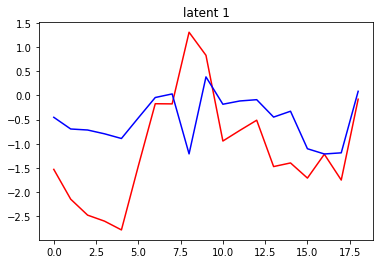

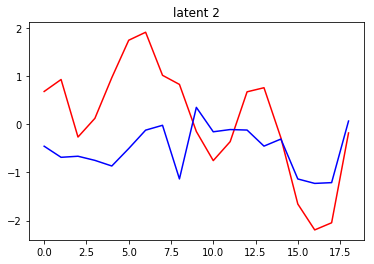

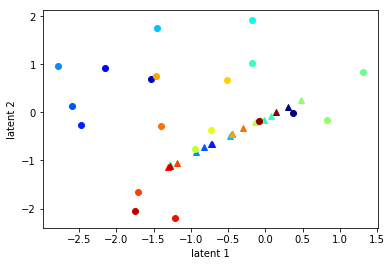

In [15]:
z_true_tr = z_true[odor_tr,:]
print(z_true_tr.shape)
zz = align_z(np.dot(qz_tr_mean, np.diag(np.sqrt(l_z_est))),z_true_tr)
plt.figure()
plt.plot(z_true_tr[:,0],'r')
plt.plot(zz[:,0],'b')
plt.title('latent 1')
plt.figure()
plt.plot(z_true_tr[:,1],'r')
plt.plot(zz[:,1],'b')
plt.title('latent 2')

# plot latent in 2d
z_est = np.zeros((N,K))
z_est[odor_tr,:] = qz_tr_mean
z_est[odor_te,:] = qz_te_mean
z_est = align_z(z_est,z_true)
print(rsquared(z_est.flatten(),z_true.flatten()))

dz = np.array(range(z_true.shape[0]))
colors = gen_color(dz)
plt.figure()
for ii in range(z_true.shape[0]):
    plt.plot(z_true[ii,0], z_true[ii,1], 'o', color=colors[ii])
    plt.plot(z_est[ii,0], z_est[ii,1], '^', color=colors[ii])
plt.xlabel('latent 1')
plt.ylabel('latent 2')


0.9730523018876709


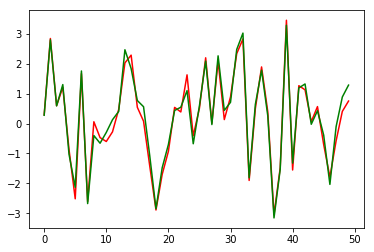

In [16]:
x_test_r2 = rsquared(x_true_avg_pred.flatten(),x_true_avg_test.flatten())
print(x_test_r2)

plt.figure()
plt.plot(x_true_avg_test.flatten(),'r')
plt.plot(x_true_avg_pred.flatten(),'g')


0.9860339641414135


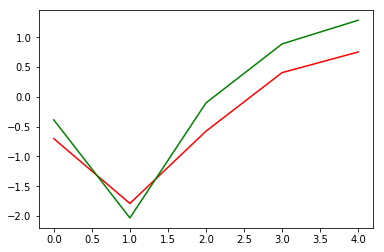

In [17]:
x_test_te_r2 = rsquared(x_true_avg_pred[:,neuron_te].flatten(),x_true_avg_test[:,neuron_te].flatten())
print(x_test_te_r2)

plt.figure()
plt.plot(x_true_avg_test[:,neuron_te].flatten(),'r')
plt.plot(x_true_avg_pred[:,neuron_te].flatten(),'g')
